In [19]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [72]:
len(words)

32033

In [73]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [119]:
# building the dataset
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [ ]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])
    
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            # compute mean and variance from current batch
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True, unbiased=True)
        else:
            # use running mean and variance for inference
            xmean = self.running_mean
            xvar = self.running_var
        
        # normalize the input
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.runnQing_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []



In [212]:
n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C]  + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [216]:
batch_size = 32
max_steps = 200000
lossi = []
for i in range(max_steps):
    # construct a mini-batch of data
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))  # 32 random indices
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch of data

    # forward pass
    emb = C[Xb]  # (batch_size, block_size, n_embed)
    X = emb.view(emb.shape[0], -1)  # (batch_size, block_size * n_embed)
    for layer in layers:
        X = layer(X)  # (batch_size, vocab_size)
    loss = F.cross_entropy(X, Yb)  # (batch_size, vocab_size) vs (batch_size,)

    # backward pass
    for layer in layers[::-1]:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()  # compute gradients

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps}: {loss.item():.4f}")
    lossi.append(loss.item())

      0/200000: 3.2890
  10000/200000: 2.4707
  20000/200000: 1.8657
  30000/200000: 1.5992
  40000/200000: 1.6016
  50000/200000: 2.0508
  60000/200000: 2.0295
  70000/200000: 2.3772
  80000/200000: 2.0025
  90000/200000: 1.6571
 100000/200000: 1.9504
 110000/200000: 2.2177
 120000/200000: 2.3200
 130000/200000: 1.7886
 140000/200000: 2.2030
 150000/200000: 2.1668
 160000/200000: 1.5174
 170000/200000: 1.9422
 180000/200000: 2.0280
 190000/200000: 2.1292


layer 1 (      Tanh): mean -0.04, std 0.76 saturated 17.16%
layer 3 (      Tanh): mean -0.01, std 0.69 saturated 12.16%
layer 5 (      Tanh): mean 0.01, std 0.67 saturated 11.25%
layer 7 (      Tanh): mean -0.02, std 0.65 saturated 8.88%
layer 9 (      Tanh): mean -0.02, std 0.67 saturated 8.81%


Text(0.5, 1.0, 'activation distributions')

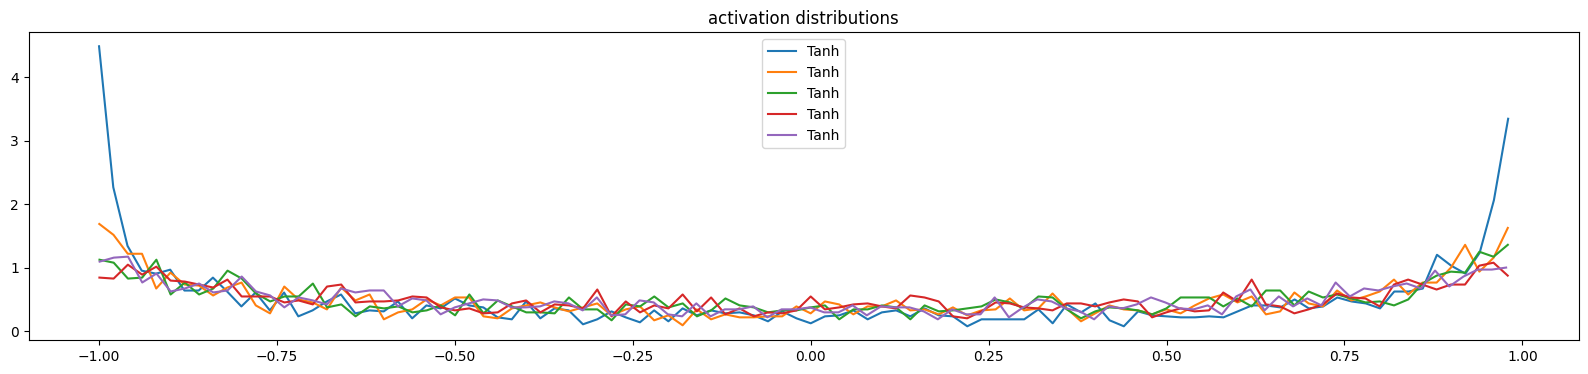

In [214]:
# visuzlize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print("layer %d (%10s): mean %.2f, std %.2f saturated %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t > 0.9).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(layer.__class__.__name__)
plt.legend(legends)
plt.title('activation distributions')

layer 1 (      Tanh): mean -0.00, std 0.00 saturated 0.00%
layer 3 (      Tanh): mean -0.00, std 0.00 saturated 0.00%
layer 5 (      Tanh): mean 0.00, std 0.00 saturated 0.00%
layer 7 (      Tanh): mean -0.00, std 0.00 saturated 0.00%
layer 9 (      Tanh): mean -0.00, std 0.00 saturated 0.00%


Text(0.5, 1.0, 'gradient distributions')

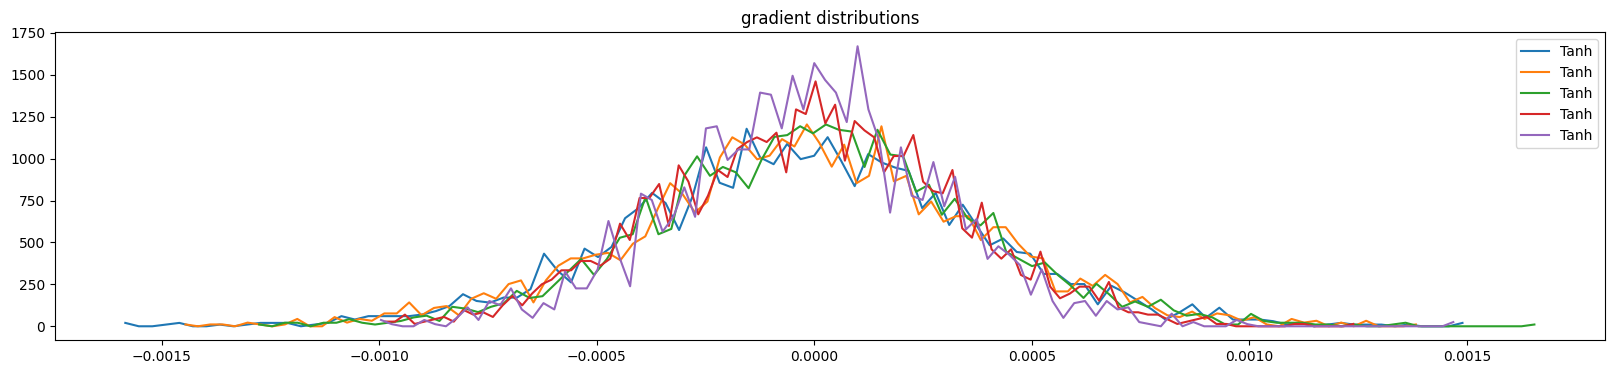

In [215]:
# visuzlize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print("layer %d (%10s): mean %.2f, std %.2f saturated %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t > 0.9).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(layer.__class__.__name__)
plt.legend(legends)
plt.title('gradient distributions')

In [217]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    X = emb.view(emb.shape[0], -1)
    for layer in layers:
        X = layer(X)
    loss = F.cross_entropy(X, y)
    print(f"{split} loss: {loss.item():.4f}")
split_loss('train')
split_loss('val')

train loss: 1.9639
val loss: 2.0920


In [226]:
# sample from the model
g = torch.Generator().manual_seed(2147483647+ 10)
for i in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        X = emb.view(emb.shape[0], -1)
        for layer in layers:
            X = layer(X)
        probs = F.softmax(X, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print(''.join(itos[i] for i in out))

montaymyah
seel
nihaham
reisha
endra
gradelyn
elin
shi
jenne
eison
anaraelyzamarkelin
shubergiadhie
trick
welle
jettalayzer
ged
ryyah
fael
yuma
myston
